# <u>Aquaverse Short Course Part I:</u> Leveraging Mixture Density Networks to Estimate Biogeochemical Parameters from Optical Remote Sensing data

This notebook provides introduces users to the Machine Learning (ML) framework called Mixture Density Networks (MDNs). MDNs are a variant of a classical neural network which estimate the final output as a <b>distribution </b> rather than a single <i>point</i> value. The four sections in this notebook walks users through:<br>

<ol> 
    <li> Importing the Science System and Applications Inc. (SSAI)'s Freshwater Sensing Group's MDN distribution into the python environment.</li>
    <li> Introducing MDNs, their architecture, and the stucture of the outputs. </li>
    <li> Downloading the <a href="https://doi.pangaea.de/10.1594/PANGAEA.948492"> GLObal Reflectance community dataset for Imaging and optical sensing of Aquatic environments (GLORIA)</a> dataset.</li>
    <li> Using the GLORIA dataset to extract predictions of biogeochemical parameters from the remote sensing reflectance and comparing those MDN predictions to ground truth measurements as well as predictions from other algorithms.</li>
</ol>


Freshwater Sensing Group </br>
Science Systems and Applications, Inc./ NASA Goddard Spaceflight Center.</br>
September 2024
<p><b style="color:blue"> Contact Info:</b> </p>
<p><u>BPs & IOP Products:</u><b> Ryan E. O'Shea:</b>  ryan.oshea@ssaihq.com (ryan.e.o'shea@nasa.gov)</p>
<p><u>Uncertainties:</u><b> Arun Saranathan:</b> arun.saranathan@ssaihq.com (fnu.arunmuralidharansaranathan@nasa.gov)</p>
<p><u>Atmospheric Correction:</u><b> Akash Ashapure:</b>  akash.ashapure@ssaihq.com (akash.ashapure@nasa.gov)</p>

<b><font size="+1" color="red">Section 1: MDN Package Import and Verification</font></b>

In [1]:
'Import the base python packages needed for this notebook'
import numpy                                                          as np
import os
from   pathlib                    import Path
from   urllib.request             import urlretrieve
import zipfile
import matplotlib                                                     as mpl
import matplotlib.pyplot                                              as plt
from   matplotlib.colors          import LogNorm

'Import some MDN specific functions and packages'
from   MDN                        import get_sensor_bands, get_tile_data
from   MDN                        import current_support 
from   MDN                        import get_gloria_trainTestData, get_args
from   MDN                        import get_mdn_preds, create_scatterplots_trueVsPred, performance
from   MDN                        import OC, resample_Rrs 

In [2]:
'Set display parameters for MATPLOTLIB'
plt.rcParams.update({
"text.usetex": True,
"font.family": "sans-serif",
"font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.default']='regular'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
mrkSize = 15
ASPECT="auto"
cmap = "jet"

mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

Aquaverse's current MDN package consists of 12 different sensor/product combinations to predict specific biogeochemical parameters (BPs) and Inherent Optical Parameters (IOPS) from optical remote sensing data. The sensors supported at present are:

<ol> 
    <li>Operational Land Imager (OLI) from the LandSat (L8) mission.</li>
    <li>MultiSpectral Instrument (MSI) from the Sentinel-2 (S2A/B) mission.</li>
    <li>Ocean and Land Colour Imager (OLCI) from the Sentinel-3 (S3A/B) mission.</li>
    <li>HyperSpectral Imager for the Coastal Ocean (HICO) from the International Space Station (ISS).</li>
    <li>Ocean Color Instrument (OCI) from the Phytoplankton, Aerosol, Cloud, ocean Ecosystem (PACE) mission.</li>
</ol>


The products generated by our MDN models at present are the following:
<ul> 
    <li> Biogeochemical Parameters</li>
    <ol> 
        <li> Chlorophyll-a (<i>chl</i>)</li>
        <li> Total Suspended Solids (<i>tss</i>)</li>
        <li> Phycocyanin (<i>pc</i>)</li>
    </ol>
</ul>

<ul>
    <li> Inherent Optical Parameters</li>
    <ol>
        <li> Absorption by colored dissolved organic materials at 440 nm (<i>cdom</i>)</li>
        <li> Spectral absorptions by colored dissolved organic matter (gelbstoff, <i>ag</i>)</li>
        <li> Spectral absorptions by non-algal particles (detritus, <i>ad</i>)</li>
        <li> Spectral absorptions by phytoplankton (<i>aph</i>)</li>
    </ol>
</ul>

[Note: The IOPs are produced in the spectral range 400-700nm, at varying spectral resolutions.]

The cell below lists all the product/sensor model combinations available as part of the current package.

In [3]:
'Print all the product/sensor model combinations available in the current MDN tool box'
current_support()

Model-1: predicts chl,tss,cdom from OLI data
Model-2: predicts chl from OLI data
Model-3: predicts chl,tss,cdom from OLCI data
Model-4: predicts chl from OLCI data
Model-5: predicts chl,tss,cdom from MSI data
Model-6: predicts chl from MSI data
Model-7: predicts chl,tss,cdom,pc from S3A data
Model-8: predicts chl,tss,cdom,pc from S3B data
Model-9: predicts aph,chl,tss,pc,ad,ag,cdom from HICO data
Model-10: predicts aph,chl,tss,pc,ad,ag,cdom from PRISMA data
Model-11: predicts aph,chl,tss,pc,ad,ag,cdom from PACE data
Model-12: predicts aph,chl,tss,pc,ad,ag,cdom from PACE-sat data


In general, if there are two models available that produce the same product, the one with more simultaneous products is expected to produce more accurate retrievals. 

<b> <font size="+1" color="red">Section 2: A Brief Introduction to Inverse Modeling and MDNs</font></b>

<p> Classical ML-based regression algorithms assume that the causal factors affecting a system are known and the ML-model attempts to learn/predict a dependant variable measuring a specific property of the system. For aquatic systems BP's and IOPs can be thought of as the causal factors which affect the color of the water column. The various Ocean Color (OC) sensors measure a dependant variable in the form of the Remote Sensing Reflectance (Rrs). Due to this difference, the task of inferring the BPs and IOPs from the Rrs is referred to as an Inverse Problem [Mobley et al. 1994]. Most systems are Many-to-One, that is there are many possible combinations of the causal factors (BPs) which can generate a specific observation (Rrs), this means that the output distribution for most inverse problems is multi-modal. Classical ML approaches assume that there is a single output for each input (unimodal) and therefore are not well-suited for modeling the relationship between the variables of an inverse problem. </p>

<p> Mixture Density Networks (MDNs) [Bishop 1994] are a neural network variant, which instead of predicting a specific value as an output, instead predicts the probability distribution of the output variable. Specifically, the MDN model outputs a Mixture of Gaussians (MoG), which can model any aribitrarily complex distribution (given enough mixture components), making them better suited for such inverse problems. The literature contains signficant proof that the BP/IOP estimates generated by an MDN are particularly well-suited for inverse modeling in optically complex eutrophic inland and coastal waters, often outperforming both classical ML models as well as operational band-ratio and line-height based OC algorithms [Smith et al. 2020, Pahlevan et al. 2021, O'Shea et al. 2023, etc.]. 
    
The full processing pipeline used to estimate BPs and IOPs from Rrs is shown in Fig. 1 below (from O'Shea et al. 2023). First, proven band ratios (BRs) and Line Heights (LHs) are calculated from, and appended to, the input Rrs. Next, the input is normalized between -1 and 1 and run through the weights of a standard neural network. The difference between MDNs is the output layer, the mixture of Gaussians, which each have an associated mean, standard deviation, and probability. Finally, the product is retrieved via a combination function, which selects the mean value of the highest probability mixture as the final estimate.  </p> </br>

<center>
<div style="border: 2px solid black; padding: 10px; width: fit-content; display: inline-block;">
    <img src="images/oshea_mdn_pipeline.jpg" alt="MDN processing pipeline" width="800" height="600" style="display: block; margin-bottom: 5px;" />
    <div style="text-align: center; font-family: Arial, sans-serif; font-size: 16px; color: #777;">
        Fig. 1: MDN pipeline to estimate BPs/IOPs from Rrs.
    </div>
</div>
</center>

<b><font size="+1" color="red">Section 3: Download and Process the <a href="https://doi.pangaea.de/10.1594/PANGAEA.948492"> GLObal Reflectance community dataset for Imaging and optical sensing of Aquatic environments (GLORIA)</a> Dataset.</font></b>

In [4]:
'Let us first download the GLORIA dataset if not available'
if not os.path.exists("data"):
    print(f"Target folder not found. Creating folder data in {os.getcwd()}")
    os.makedirs("data")

if not os.path.exists("data/GLORIA-2022.zip"):
    !curl -o data/GLORIA-2022.zip https://download.pangaea.de/dataset/948492/files/GLORIA-2022.zip

In [5]:
'Set up the details and extract the GLORIA data to a folder called GLORIA-2022'
zip_file_path = 'data/GLORIA-2022.zip'  # Replace with your zip file path
extract_to_dir = 'data/'                # Replace with your extraction directory

'Unzip the downloaded zip file'    
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)
    print(f'Files extracted to {extract_to_dir}')



Files extracted to data/


The GLORIA dataset contains hyperspectral Rrs samples with wavelengths in the range of 350-800 nm, interpolated to a 1 nm resolution. For training MDN models that will be applicable to the OC satellites of interest, these spectra need to be resampled to the spectral range and resolution of each instrument. The spectral resampling is done by using the instrument's Relative Spectral Response (RSR) function. Further, the data is also split into a training dataset and a test dataset. The training dataset is the same one that was used to train the model you will be evaluating in this notebook via the test dataset.

In [6]:
'Set the GLORIA folder and extract the data'
gloria_folder = Path().cwd() / 'data/GLORIA_2022/'

assert gloria_folder.is_dir(), f"No folder found art {gloria_folder}"

'Get the GLORIA data at the resolution of the OLCI sensor, split into training (_train) and test (_test) datasets.'
x_train, y_train, x_test, y_test, gid_train, gid_test = get_gloria_trainTestData(sensor="OLCI", out_var=["chl"],
                                                        save_flag=False, load_exists=False, rand_seed=42,
                                                        rem_flagged=True, gloria_folder=gloria_folder,
                                                        flag_name='GLORIA_qc_flags.csv', rrs_name='GLORIA_Rrs.csv',
                                                        bg_name='GLORIA_meta_and_lab.csv', gloria_only=True,
                                                        train_mode=True)
'Get the wavelengths available for this sensor'
wvl_bands = get_sensor_bands("OLCI")

  1%|▉                                                                                                                                                     | 49/7572 [00:00<00:15, 485.87it/s]

Bands with responses outside of range [350, 899]: 
 [900.0, 940.0, 1020.0]

Creating data for bands
 [400.0, 412.5, 442.5, 490.0, 510.0, 560.0, 620.0, 665.0, 673.75, 681.25, 708.75, 753.75, 761.25, 764.375, 767.5, 778.75, 865.0, 885.0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7572/7572 [00:14<00:00, 511.66it/s]


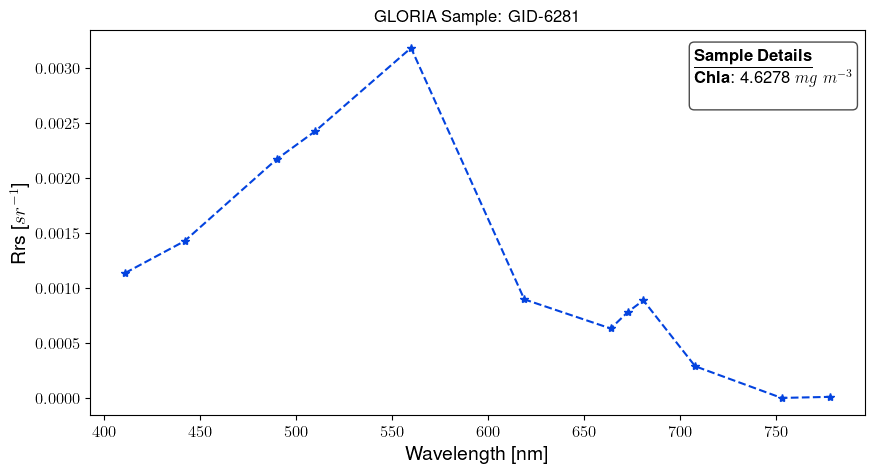

In [7]:
'Let us visualize a sample from the Gloria data to get a sense of what they look like'
idx = 180    #np.random.choice(x_data.shape[0])
fig1 = plt.figure(figsize=(10,5))
plt.plot(wvl_bands, np.squeeze(x_train[idx, :]), linestyle="--", marker="*", color="xkcd:blue")
plt.title("GLORIA Sample: " + gid_train[idx].replace('_', '-'));
plt.xlabel('Wavelength [nm]');
plt.ylabel(r'Rrs [$sr^{-1}$]');
ax = plt.gca()

label= []
for item in y_train[idx, :]:
    if np.isnan(item):
        label += ['N/A']
    else:
        label+= [f'{item:.4f}']

textstr1 = (r"\underline{\textbf{Sample Details}}" + '\n' + r"\textbf{Chla}:" + f' {label[0]} ' + r"$mg~m^{-3}$" + '\n')
           #+ r"\textbf{TSS:}" + f'           {label[1]} ' + r"$mg~m^{-3}$" + '\n'  + r"\textbf{acdom:}" + f'    {label[2]} ' + r"$m^{-1}$ " + '\n');
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.78, 0.95, textstr1, transform=ax.transAxes, fontsize=SMALL_SIZE*1, weight="bold", verticalalignment='top', bbox=props);

Now that we have split tthe GLORIA Rrs samples into training and test datasets matching OLCI's resolution, we can now move on to using the MDN to make predictions for each of the spectra in the GLORIA database and evaluating the MDNs performance using the test dataset. 

<b><font size="+1" color="red">Section 4: Using Pre-trained Mixture Density Networks to Retrieve BPs</font></b>

First, we will retrieve model predictions on the training samples. The purpose of this step is two-fold, first it acts as a sanity check to ensure that the model performs as expected and second it provides a best case scenario for the model performance which will act as a baseline against operational algorithms.

In [8]:
mdn_preds_train, mdn_preds_desc = get_mdn_preds(x_train, sensor="OLCI", products="chl", mode="point", model_type='testing')

  0%|                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]

MDN model settings not provided by user!
Looking for model at OLCI resolution predicting chl!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


To get the predictions of the trained MDN models on spectral data you can use the function <a style="font-family:'Courier New'">get_mdn_preds</a>. The first input is a numpy matrix with shape <a style="font-family:'Courier New'">nSamples X nBands</a>. The second is the sensor which the spectral data corresponds to. The third selects the products. The fourth parameter (mode) controls what the model output looks like, more information on this aspect will be given in the [next notebook](SC_2_MDNs_with_satellite_imagery.ipynb)). The final parameter <a style="font-family:'Courier New'">model_type='testing'</a> is simply used to tell the package that we are using the model trained on half the data as were testing the model-performance. For generating actual satellite maps or predictions on new spectral data of interest, you should set <a style="font-family:'Courier New'">model_type='production'</a> (or you can not specify this parameter as <a style="font-family:'Courier New'">model_type='production'</a> is the default behavior). Setting the model type to production will enable the use of a model trained on all available data (our published datasets), which are expected to be the best models available. 


The function generates two output parameters, namely <a style="font-family:'Courier New'">mdn_preds_train</a>, which contains the output from the mdn, and <a style="font-family:'Courier New'">mdn_preds_desc</a>, which is a dictionary containing the details of the starting and ending column for each output variable.

Now that we know the different outputs available from the MDN model, let us check the quality of the model's prediction  performance on the dataset used for training (which will give overly accurate estimates relative to out of training samples).

In [9]:
'Compare the true and predicted values and get a set of regression metrics'
inp_str = []
for key in mdn_preds_desc:
    str1 = (performance(f'', y_train[:, mdn_preds_desc[key]], mdn_preds_train[:, mdn_preds_desc[key]]).replace('|', ''))
    inp_str += [str1.replace('   ', '\n')]

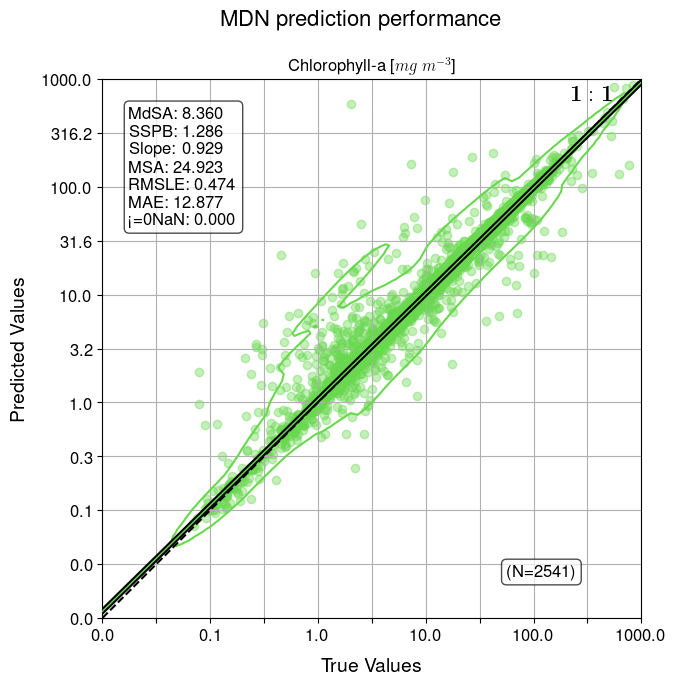

In [10]:
'Show a graphical comparision of the true and predicted values'
create_scatterplots_trueVsPred(y_train, mdn_preds_train, short_name=[r'Chlorophyll-a [$mg~m^{-3}$]'], 
                               x_label=['True Values'], y_label=['Predicted Values'], inplot_str=inp_str,
                               title="MDN prediction performance", maxv_b=[3], minv_b=[-2], ipython_mode=True)

The scatterplot above shows a graphical comparision between the true and predicted values. Additionally the plot also shows the values of a various regression metrics which can be used to provide a wholesale analysis of the regression performance. For more detailed description of the various metrics see Section 3.2 of <a href="https://www.frontiersin.org/journals/remote-sensing/articles/10.3389/frsen.2024.1383147/full"> Saranathan et al. 2024</a>. While these plots show exceptional performance it is worth noting that the performance on novel test samples will not be as good. To illustrate this let us test the performance on these models on the test samples. Further let us also get estimates from the classical OC model for comparision

In [11]:
'Get MDN predictions on test samples'
mdn_preds_test, _ = get_mdn_preds(x_test, sensor="OLCI", products="chl", mode="point", model_type='testing')

'Get predictions from the OC model'
oc_preds_test = OC(x_test, wvl_bands, sensor="OLCI", algorithm='OC', num=3)

 20%|██████████████████████████████▊                                                                                                                           | 2/10 [00:00<00:00, 13.42it/s]

MDN model settings not provided by user!
Looking for model at OLCI resolution predicting chl!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.59it/s]


In [12]:
'Compare the true and predicted values and get a set of regression metrics for MDN on the test set'
inp_str = []
for key in mdn_preds_desc:
    str1 = (performance(f'', y_test[:, mdn_preds_desc[key]], mdn_preds_test[:, mdn_preds_desc[key]]).replace('|', ''))
    inp_str += [str1.replace('   ', '\n')]

'Compare the true and predicted values and get a set of regression metrics for OC on the test set'
for key in mdn_preds_desc:
    str1 = (performance(f'', y_test[:, mdn_preds_desc[key]], oc_preds_test[:, mdn_preds_desc[key]]).replace('|', ''))
    inp_str += [str1.replace('   ', '\n')]

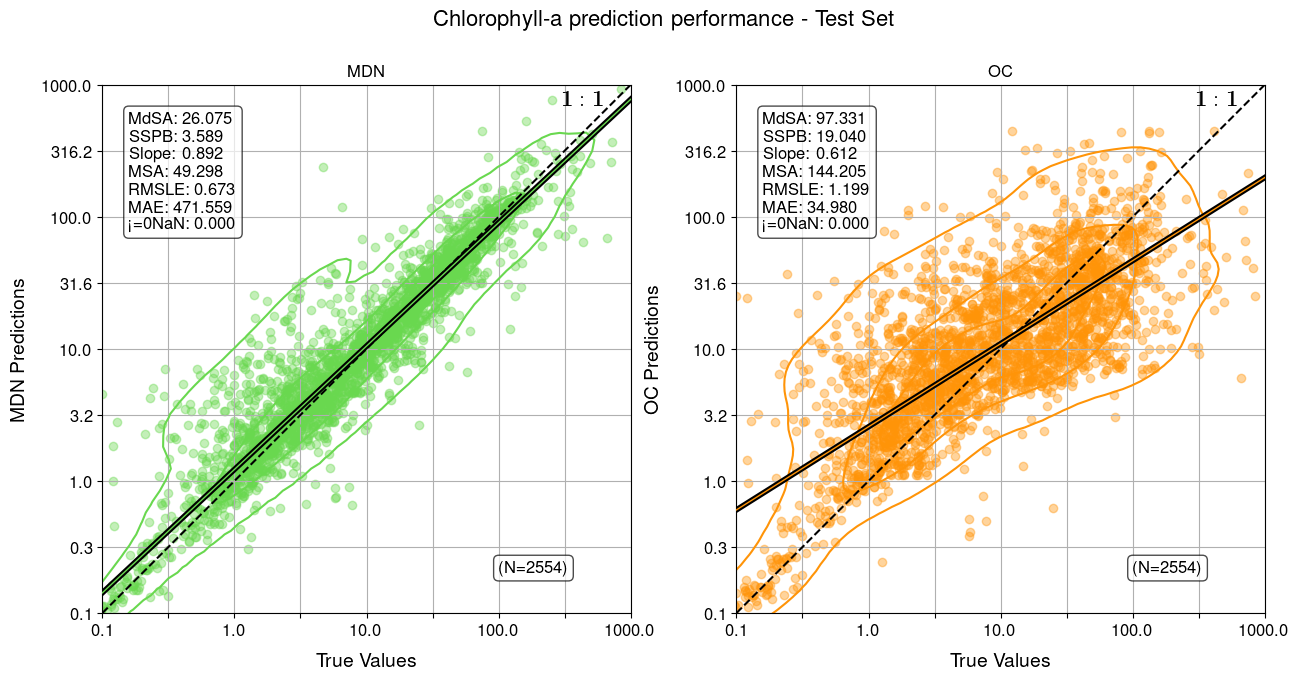

In [13]:
'Show a graphical comparision of the true and predicted values'
create_scatterplots_trueVsPred(np.hstack((y_test, y_test)), np.hstack((mdn_preds_test, oc_preds_test)), short_name=[r'MDN', r'OC'], 
                               x_label=['True Values', 'True Values'], y_label=['MDN Predictions', 'OC Predictions'], inplot_str=inp_str,
                               title="Chlorophyll-a prediction performance - Test Set", maxv_b=[3, 3], minv_b=[-1, -1], ipython_mode=True)


Across a large variety of regression metrics the MDN outperforms most semi-analytical algorithms across the full suite of the regression metrics under consideration.

<b><font size="+1" color="red">Section 5: Using Pre-trained <u>Production</u> Mixture Density Networks to Retrieve BPs</font></b>

User's can also retrieve multiple products from alternative models. Change the <b>"out_var" to ["chl","tss","cdom"]</b> to retrieve additional outputs from the GLORIA database.

In [14]:
x_train, y_train, x_test, y_test, gid_train, gid_test = get_gloria_trainTestData(sensor="OLCI", out_var=["chl","tss","cdom"],
                                                        save_flag=False, load_exists=False, rand_seed=42,
                                                        rem_flagged=True, gloria_folder=gloria_folder,
                                                        flag_name='GLORIA_qc_flags.csv', rrs_name='GLORIA_Rrs.csv',
                                                        bg_name='GLORIA_meta_and_lab.csv', gloria_only=True,
                                                        train_mode=True)

  1%|▉                                                                                                                                                     | 48/7572 [00:00<00:15, 478.68it/s]

Bands with responses outside of range [350, 899]: 
 [900.0, 940.0, 1020.0]

Creating data for bands
 [400.0, 412.5, 442.5, 490.0, 510.0, 560.0, 620.0, 665.0, 673.75, 681.25, 708.75, 753.75, 761.25, 764.375, 767.5, 778.75, 865.0, 885.0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7572/7572 [00:15<00:00, 504.68it/s]


<u>For retrievals from your own test data, users should use production models instead.</u> In the below code block, change the <b>products to "chl,tss,cdom"</b> and <b>model_type to 'production'</b>. 

In [15]:
'Get MDN predictions on test samples'
mdn_preds_test, mdn_preds_desc = get_mdn_preds(x_test, sensor="OLCI", products="chl,tss,cdom", mode="point", model_type='production')

 20%|██████████████████████████████▊                                                                                                                           | 2/10 [00:00<00:00, 14.02it/s]

MDN model settings not provided by user!
Looking for model at OLCI resolution predicting chl,tss,cdom!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.14it/s]


In [16]:
'The outputs slices are described in the mdn_preds_desc'
for key in mdn_preds_desc:
    print(f'The outputs available are {key} and correponds to the {mdn_preds_desc[key]}')

The outputs available are chl and correponds to the slice(0, 1, None)
The outputs available are tss and correponds to the slice(1, 2, None)
The outputs available are cdom and correponds to the slice(2, 3, None)


In [17]:
'Ouptuts for a specific product can be accessed as below'
key = "chl"
MDN_chl_preds = mdn_preds_test[:, mdn_preds_desc[key]]
chl_test_data = y_test[:, mdn_preds_desc[key]]

In [18]:
'Compare the true and predicted values and get a set of regression metrics'
inp_str = []
for key in mdn_preds_desc:
    str1 = (performance(f'', y_test[:, mdn_preds_desc[key]], mdn_preds_test[:, mdn_preds_desc[key]]).replace('|', ''))
    inp_str += [str1.replace('   ', '\n')]

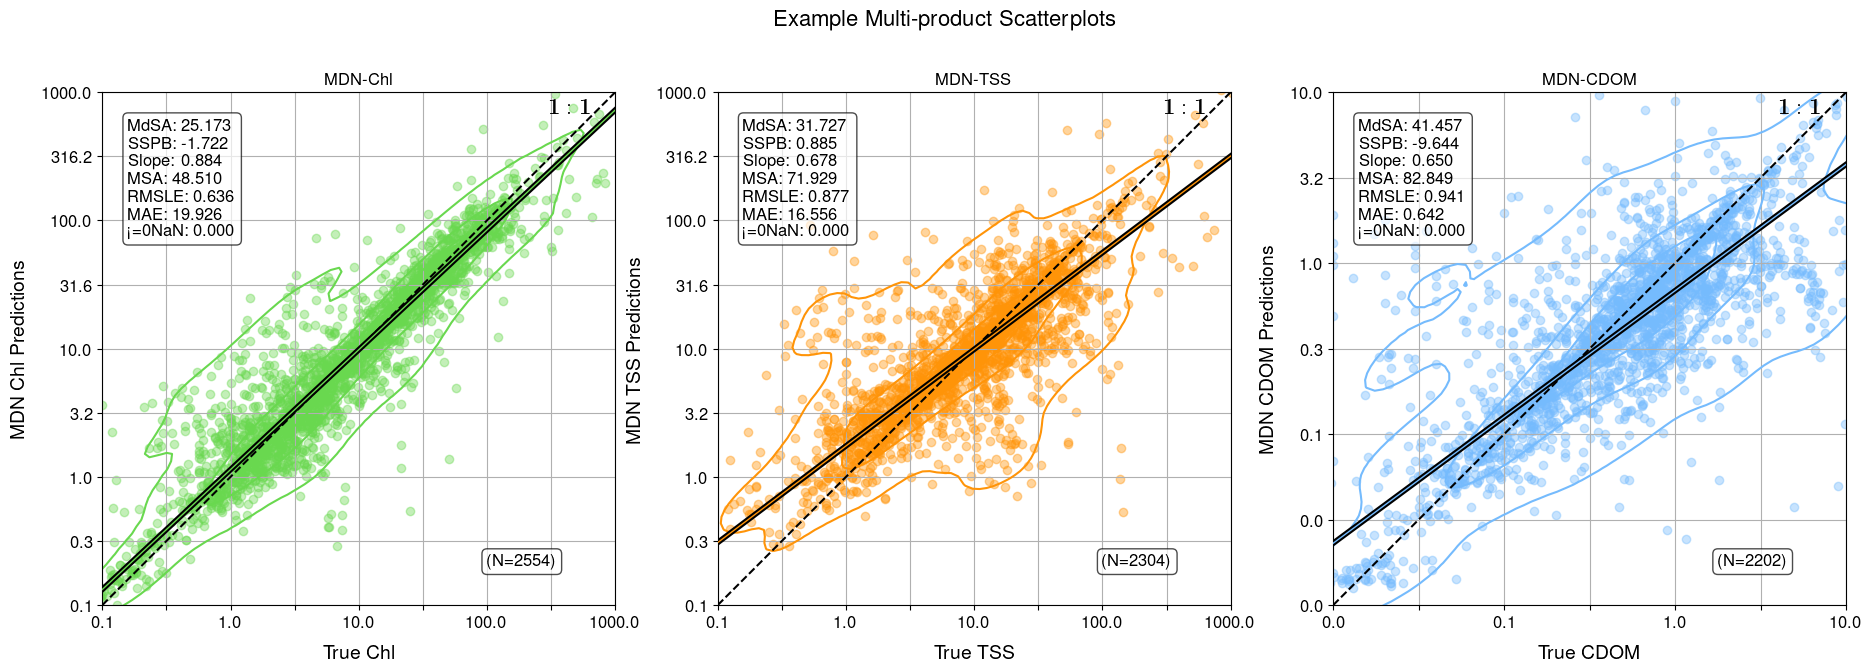

In [19]:
'Show a graphical comparision of the true and predicted values'
create_scatterplots_trueVsPred(np.hstack(( y_test[:, mdn_preds_desc["chl"]], y_test[:, mdn_preds_desc["tss"]],y_test[:, mdn_preds_desc["cdom"]])), np.hstack((mdn_preds_test[:, mdn_preds_desc["chl"]], mdn_preds_test[:, mdn_preds_desc["tss"]],mdn_preds_test[:, mdn_preds_desc["cdom"]])), short_name=[r'MDN-Chl', r'MDN-TSS', r'MDN-CDOM'], 
                               x_label=['True Chl', 'True TSS', 'True CDOM'], y_label=['MDN Chl Predictions', 'MDN TSS Predictions', 'MDN CDOM Predictions'], inplot_str=inp_str,
                               title="Example Multi-product Scatterplots", maxv_b=[3, 3, 1], minv_b=[-1, -1, -2], ipython_mode=True)


<b>This scatterplot is simply an example using the GLORIA dataset for multiple product retrievals, and it is not necesarily representative of actual expected errors/residuals. For actual error metrics for individual models please refer to the references specific to each sensor combination below.</b>

<b><font size="+1" color="red">Section 6: Resampling In-situ Hyperspectral Rrs for input to Sensor Specific Mixture Density Networks</font></b>

The below code block resamples <b>GLORIA</b> data to 'hyperspectral' wavelengths (1 nm resolution), then resamples it to another sensors specific resolution. If you have your own <i>in situ</i> hyperspectral Rrs, this code can be used to make predictions from the sensor specific MDN's (e.g., OLCI or OLI) from your in situ data via the <a style="font-family:'Courier New'">get_mdn_preds'</a>  and <a style="font-family:'Courier New'">create_scatterplots_trueVsPred'</a>   functions, as shown below for OLI.

In [20]:
'Loads the GLORIA database at hyperspectral wavelengths, which will be resampled to sensor specific wavelengths'
x_train, y_train, x_test, y_test, gid_train, gid_test = get_gloria_trainTestData(sensor="HYPER", out_var=["chl","tss","cdom"],
                                                        save_flag=False, load_exists=False, rand_seed=42,
                                                        rem_flagged=True, gloria_folder=gloria_folder,
                                                        flag_name='GLORIA_qc_flags.csv', rrs_name='GLORIA_Rrs.csv',
                                                        bg_name='GLORIA_meta_and_lab.csv', gloria_only=True,
                                                        train_mode=True)


  0%|▏                                                                                                                                                       | 7/7572 [00:00<02:04, 60.76it/s]

Bands with responses outside of range [350, 899]: 
 []

Creating data for bands
 [400.0, 401.0, 402.0, 403.0, 404.0, 405.0, 406.0, 407.0, 408.0, 409.0, 410.0, 411.0, 412.0, 413.0, 414.0, 415.0, 416.0, 417.0, 418.0, 419.0, 420.0, 421.0, 422.0, 423.0, 424.0, 425.0, 426.0, 427.0, 428.0, 429.0, 430.0, 431.0, 432.0, 433.0, 434.0, 435.0, 436.0, 437.0, 438.0, 439.0, 440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447.0, 448.0, 449.0, 450.0, 451.0, 452.0, 453.0, 454.0, 455.0, 456.0, 457.0, 458.0, 459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 465.0, 466.0, 467.0, 468.0, 469.0, 470.0, 471.0, 472.0, 473.0, 474.0, 475.0, 476.0, 477.0, 478.0, 479.0, 480.0, 481.0, 482.0, 483.0, 484.0, 485.0, 486.0, 487.0, 488.0, 489.0, 490.0, 491.0, 492.0, 493.0, 494.0, 495.0, 496.0, 497.0, 498.0, 499.0, 500.0, 501.0, 502.0, 503.0, 504.0, 505.0, 506.0, 507.0, 508.0, 509.0, 510.0, 511.0, 512.0, 513.0, 514.0, 515.0, 516.0, 517.0, 518.0, 519.0, 520.0, 521.0, 522.0, 523.0, 524.0, 525.0, 526.0, 527.0, 528.0, 529.0, 530.0, 5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7572/7572 [02:04<00:00, 61.03it/s]


In [21]:
'Replace with measured hyperspectral wavelengths'
wvl_in        = get_sensor_bands('HYPER')

'Replace with measured in situ hyperspectral Rrs corresponding rows representing samples and columns representing wvl_in' 
Rrs_data      = x_test

'Replace with in situ measured BPs, aligned by rows, in the same order as the products list below (e.g., chl,tss,cdom)'
insitu_data   = y_test

'Resample to another sensor: OLI'
resampled_Rrs, wvls_resampled = resample_Rrs(Rrs_data, wvl_in, sensor="OLI")
print("")
print(f"Wavelengths resampled to {len(wvls_resampled)} bands:", wvls_resampled)
print( "Rrs has shape corresponding to samples x bands:", np.shape(resampled_Rrs))



  2%|███▎                                                                                                                                                  | 82/3759 [00:00<00:04, 816.58it/s]

Bands with responses outside of range [400, 798]: 
 [864.6699829101561, 1608.8599853515625, 2200.72998046875, 1373.4300537109375]

Creating data for bands
 [442.95999145507807, 482.0400085449218, 561.4099731445312, 654.5900268554688, 589.5]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3759/3759 [00:04<00:00, 843.71it/s]


Wavelengths resampled to 4 bands: [443 482 561 655]
Rrs has shape corresponding to samples x bands: (3759, 4)


In [22]:
'Get MDN predictions on test samples'
mdn_preds_test, mdn_preds_desc = get_mdn_preds(resampled_Rrs, sensor="OLI", products="chl,tss,cdom", mode="point", model_type='production')

 20%|██████████████████████████████▊                                                                                                                           | 2/10 [00:00<00:00, 13.91it/s]

MDN model settings not provided by user!
Looking for model at OLI resolution predicting chl,tss,cdom!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.20it/s]


In [23]:
'Compare the true and predicted values and get a set of regression metrics'
inp_str = []
for key in mdn_preds_desc:
    str1 = (performance(f'', insitu_data[:, mdn_preds_desc[key]], mdn_preds_test[:, mdn_preds_desc[key]]).replace('|', ''))
    inp_str += [str1.replace('   ', '\n')]

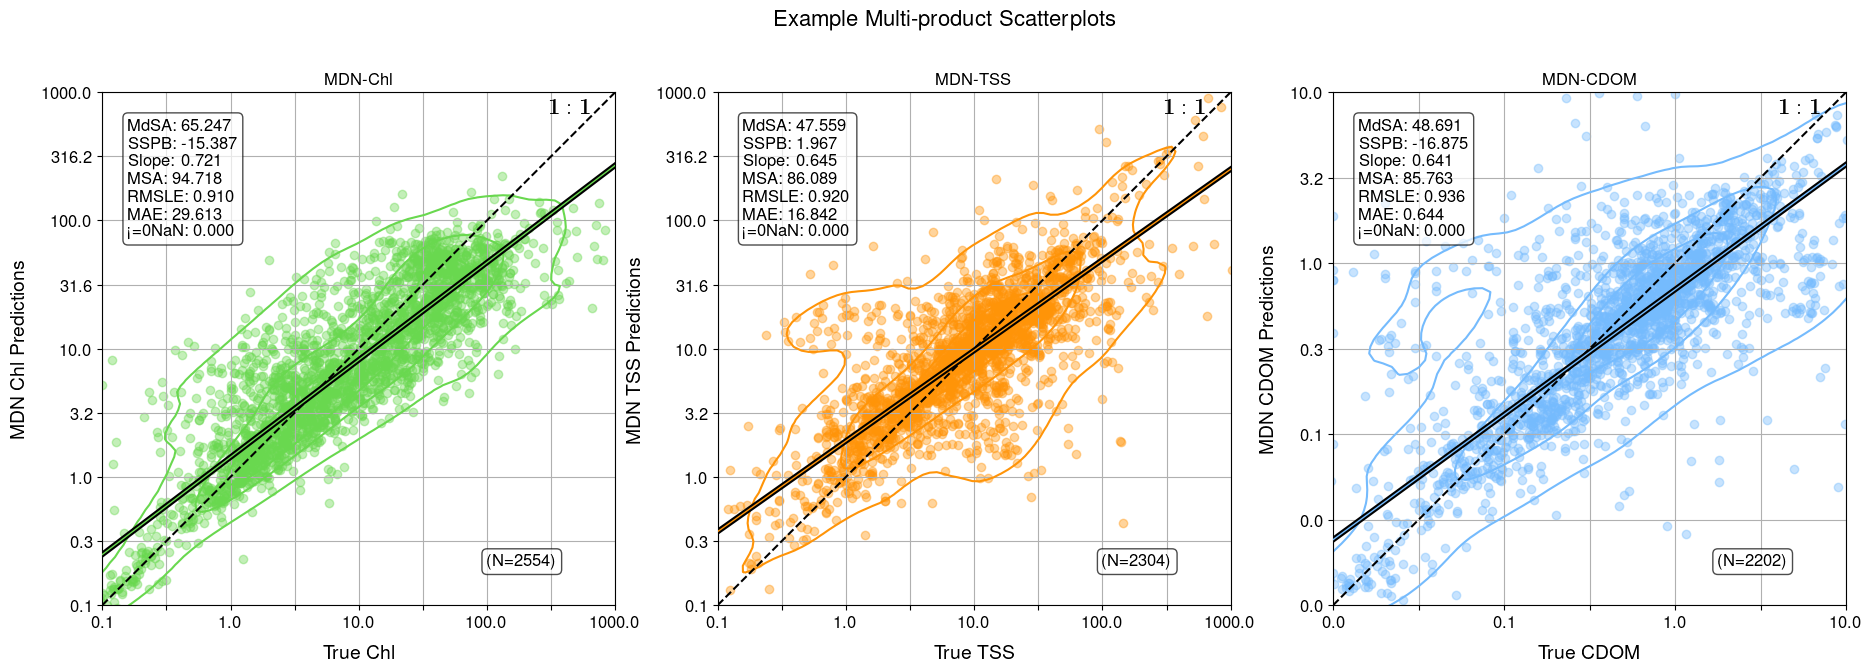

In [24]:
'Show a graphical comparision of the true and predicted values'
create_scatterplots_trueVsPred(np.hstack(( insitu_data[:, mdn_preds_desc["chl"]], insitu_data[:, mdn_preds_desc["tss"]],insitu_data[:, mdn_preds_desc["cdom"]])), np.hstack((mdn_preds_test[:, mdn_preds_desc["chl"]], mdn_preds_test[:, mdn_preds_desc["tss"]],mdn_preds_test[:, mdn_preds_desc["cdom"]])), short_name=[r'MDN-Chl', r'MDN-TSS', r'MDN-CDOM'], 
                               x_label=['True Chl', 'True TSS', 'True CDOM'], y_label=['MDN Chl Predictions', 'MDN TSS Predictions', 'MDN CDOM Predictions'], inplot_str=inp_str,
                               title="Example Multi-product Scatterplots", maxv_b=[3, 3, 1], minv_b=[-1, -1, -2], ipython_mode=True)


<b style="color:blue"> References:</b> 
<p><u><b>BP & IOP Products:</b></u>
<p><i>Sensors: <b>OLCI & MSI</b> Products: <b>chl</b></i>
    
1. <a href="https://doi.org/10.1016/j.rse.2019.111604"> Seamless retrievals of chlorophyll-a from Sentinel-2 (MSI) and Sentinel-3 (OLCI) in inland and coastal waters: A machine-learning approach</a>. N. Pahlevan, et al. (2020). Remote Sensing of Environment. 111604.10.1016/j.rse.2019.111604.      </p>

<p><i>Sensors: <b>OLI</b> Products: <b>chl</b></i>
    
2. <a href="https://doi.org/10.3389/frsen.2020.623678"> A Chlorophyll-a Algorithm for Landsat-8 Based on Mixture Density Networks</a>. B. Smith, et al. (2021). Frontiers in Remote Sensing. 623678. 10.3389/frsen.2020.623678.      </p>


<p><i>Sensors:  <b>OLCI, MSI, & OLI</b> Products: <b>chl,tss,cdom</b></i>
    
3. <a href="https://doi.org/10.1016/j.rse.2021.112860"> Simultaneous retrieval of selected optical water quality indicators from Landsat-8, Sentinel-2, and Sentinel-3 </a>. Pahlevan, N. et al. (2022). Remote Sensing of Environment. 112860.  10.1016/j.rse.2021.112860.     </p>


<p><i>Sensors:  <b>HICO & PRISMA</b> Products: <b>aph,chl,tss,pc,ad,ag,cdom</b></i>
    
4. <a href="https://doi.org/10.1016/j.rse.2023.113706"> A Hyperspectral Inversion Framework for Estimating Absorbing Inherent Optical Properties and Biogeochemical Parameters in Inland and Coastal Waters</a>. O’Shea, R. E., et al. (2023). Remote Sensing of Environment. 113706. 10.1016/j.rse.2023.113706.       </p>

<p><i>Sensors:  <b>HICO & PRISMA</b> Products: <b>pc</b></i> (via aph,chl,tss,pc,ad,ag,cdom model)
    
5. <a href="https://doi.org/10.1016/j.rse.2021.112693"> Advancing cyanobacteria biomass estimation from hyperspectral observations: Demonstrations with HICO and PRISMA imagery.</a>. O’Shea, R. E., et al. (2021). Remote Sensing of Environment. 112693. 10.1016/j.rse.2021.112693.       </p>

<p><i>Sensors:  <b>OLCI (S3A/B)</b> Products: <b>pc </b></i> (via chl,tss,cdom,pc model)
    
6. <a href="https://doi.org/10.1016/j.jglr.2022.12.010"> Sensitivity of remotely sensed pigment concentration via Mixture Density Networks (MDNs) to uncertainties from atmospheric correction.</a>. Zolfaghari, K., et al. (2022). Journal of Great Lakes Research. 10.1016/j.jglr.2022.12.010.      </p>
    
<a href="https://doi.org/10.3389/frsen.2023.1157609"> Leveraging multimission satellite data for spatiotemporally coherent cyanoHAB monitoring.</a>. Fickas, K. C., et al. (2023). Frontiers in Remote Sensing. 10.3389/frsen.2023.1157609.      </p>

<p><b>SOLID:</b>  <i>Sensors:  <b>MSI</b> Products: <b>TSS  </b> </i>
    
7. <a href="https://doi.org/10.1016/j.rse.2020.111768"> Robust algorithm for estimating total suspended solids (TSS) in inland and nearshore coastal waters</a>. S.V. Balasubramanian, et al. (2020). Remote Sensing of Environment. 111768. 10.1016/j.rse.2020.111768.      </p>

<p><u><b>Uncertainties:</b></u>
    
8. <a href="https://doi.org/10.3389/frsen.2024.1383147"> Assessment of advanced neural networks for the dual estimation of water quality indicators and their uncertainties</a>. A. M. Saranathan et al. (2024). Frontiers in Remote Sensing. 10.3389/frsen.2024.1383147.     </p>


    
9. <a href="https://doi.org/10.1109/TGRS.2023.3234465"> Per-Pixel Uncertainty Quantification and Reporting for Satellite-Derived Chlorophyll-a Estimates via Mixture Density Networks</a>. A. M. Saranathan et al. (2023). IEEE Transactions on Geosciences and Remote Sensing. 10.1109/TGRS.2023.3234465.     </p>


<p><u><b>External references:</b></u> </p>

10. Light and Water: Radiative Transfer in Natural Waters. C. Mobley (1994).</p>
11. Mixture Density Networks. C. M. Bishop (1994). Aston University, Birmingham, U.K.. </p>
12. <a href="https://doi.org/10.1109/ICRA.2018.8462978"> Uncertainty-aware learning from demonstration using mixture density networks with sampling-free variance modeling.</a>.  Choi (2017). IEEE International Conference on Robotics and Automation. 10.1109/ICRA.2018.8462978.</p>